# Imports

In [1]:
from google.colab import drive # comment out if not using Google Colab for model training and GPU access
drive.mount('/content/drive') # idem

%cd /content/drive/MyDrive/chestxray-efficientnet/

import os
import yaml
import copy
import random
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.models.efficientnet_b4 import create_model
from src.data.download import ensure_data_dirs
from src.data.dataset import prepare_dataset_train, prepare_dataset_test

import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
/content/drive/MyDrive/chestxray-efficientnet


In [2]:
# install requirements from requirements.txt
!pip install -r requirements.txt

with open("configs/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg_data = cfg["data"]

# Setting up the working environment

# Loading data and building the datasets

The following cell will only load the data from the competition dropbox if necessary.

In [3]:
# ensure_data_dirs(cfg_data) # if data folders (train or test) are empty

Downaloading train data directory...
⬇️  Downloading from: https://www.dropbox.com/s/feaakvusdvkep3n/train.tar?dl=1
   Saved to: data/train.tar
📦 Extracting data/train.tar → data ...
   Extraction completed.
⬇️  Downloading from: https://www.dropbox.com/s/9kebfecemhfkj7k/train.csv?dl=1
   Saved to: data/train.csv
✅ Training data and train.csv downloaded.
Downaloading test data directory...
⬇️  Downloading from: https://www.dropbox.com/s/20d8b9z8znc2lmp/testPublic.tar?dl=1
   Saved to: data/test.tar
📦 Extracting data/test.tar → data ...
   Extraction completed.
✅ Test data downloaded.


In [3]:
ensure_data_dirs(cfg_data) # otherwise

✔ data/train already populated and train.csv found.
✔ data/test already populated.


Then, we need to set up the config information to tell our pipeline where to look for the data in our working directory

In [4]:
cfg_data["train_dir"] = "data/train"
cfg_data["test_dir"] = "data/testPublic"

Once set up is done, we can load the Pytorch datasets:
- Train data is loaded and splitted: 85% train /15% validation
- Test data is loaded

In [9]:
train_df, train_dataset, val_df, val_dataset = prepare_dataset_train(cfg_data)
test_df, test_dataset = prepare_dataset_test(cfg_data)
print()
print("Train samples :", len(train_df))
print("Val samples   :", len(val_df))
print("Test samples  :", len(test_dataset) if test_dataset else 0)


Train samples : 9035
Val samples   : 1595
Test samples  : 3544


Then, we look for class imbalance in the training and validation sets:

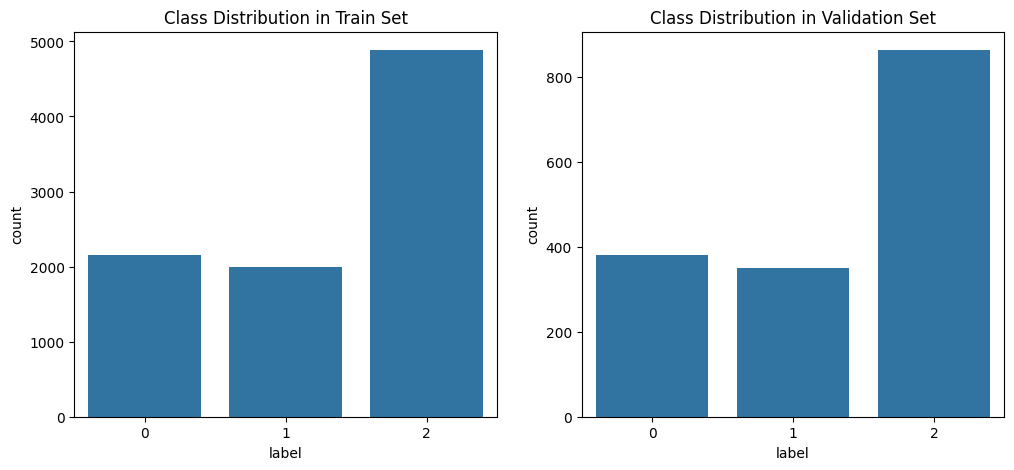

In [10]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.countplot(x=train_df["label"], ax=ax[0])
ax[0].set_title("Class Distribution in Train Set")
sns.countplot(x=val_df["label"], ax=ax[1])
ax[1].set_title("Class Distribution in Validation Set")
plt.show()

Clearly, there is some high level of class-imbalance in this dataset.

# Visualizing a few samples

In [11]:
def show_samples(dataset, n=6):
    idxs = random.sample(range(len(dataset)), n)
    imgs = []
    labels = []

    for idx in idxs:
        img, label = dataset[idx]
        imgs.append(img.permute(1, 2, 0).numpy())
        labels.append(label)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

As this point, we look at the training and validation data to check that data processing was done correctly:

Train sample images:


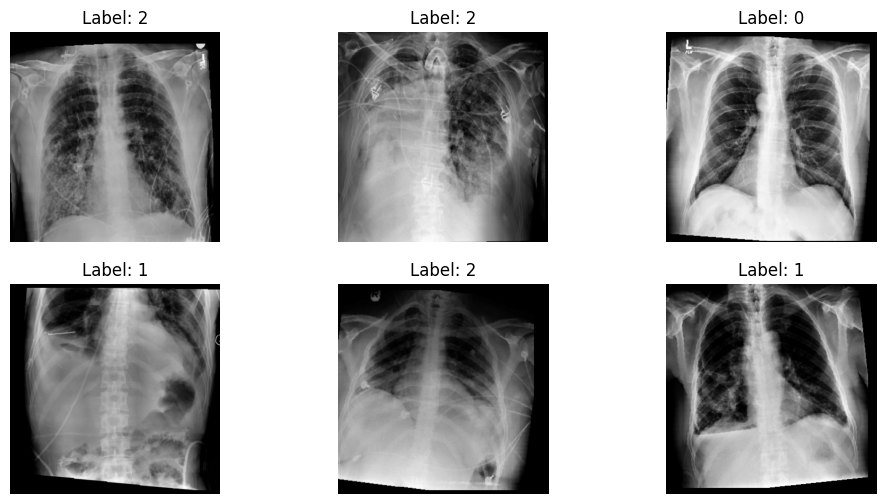


Validation sample images:


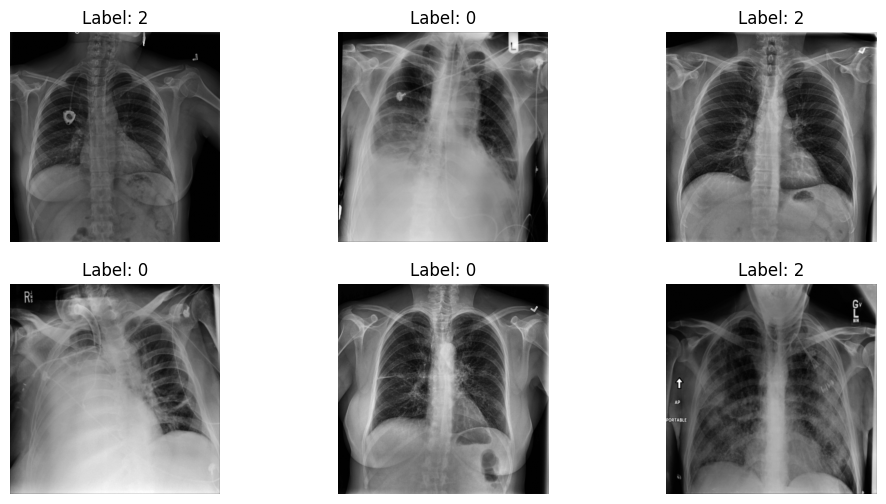

In [12]:
print("Train sample images:")
show_samples(train_dataset)
print()
print("Validation sample images:")
show_samples(val_dataset)

# Sanity Check and Model loading

Before going further, we do some simple sanity checks to verify that the model and data loading are consistent.

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=True,
    num_workers = 8,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers = 8,
    persistent_workers=True
)
device = torch.device(cfg["training"]["device"])

model = create_model(
    pretrained=cfg["model"]["pretrained"],
    num_classes=cfg["model"]["num_classes"]
).to(device)

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)

print("Batch shape:", images.shape)
print("Output shape:", outputs.shape)

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Batch shape: torch.Size([16, 1, 380, 380])
Output shape: torch.Size([16, 3])


# Model training

As we use Colab for model training, we'll start by copying the data into a content/data folder within the runtime to optimize data access. This turns out to be a massive bottleneck on Colab. If not training on Colab you can safely skip these steps. Otherwise, you can go get yourself a coffee, this should take 10min! ;)

In [ ]:
import shutil
# if training on Colab, copying the data on /content/data for faster access during training
def copy_dataset_from_drive():
    """
    Copy dataset from Drive → /content/data only if needed.
    """
    drive_data = "/content/drive/MyDrive/chestxray-efficientnet/data"
    runtime_data = "/content/data"

    # Create /content/data if missing
    os.makedirs(runtime_data, exist_ok=True)

    # If already copied, skip
    if os.path.exists(os.path.join(runtime_data, "train")):
        print("✔ Dataset already copied to /content/data")
        return runtime_data

    print("📂 Copying dataset from Drive → /content/data ...")
    shutil.copytree(drive_data, runtime_data, dirs_exist_ok=True)
    print("✅ Copy complete.")

    return runtime_data

# Run copying
runtime_data_dir = copy_dataset_from_drive()

# Change configs accordingly
cfg_data["data_dir"] = runtime_data_dir
cfg_data["train_csv"] = os.path.join(runtime_data_dir, "train.csv")

# Prepare datasets
from src.data.dataset import prepare_dataset_train, prepare_dataset_test
train_df, train_dataset, val_df, val_dataset = prepare_dataset_train(cfg_data)
test_df, test_dataset = prepare_dataset_test(cfg_data)

# Update data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=True,
    num_workers = 8,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers = 8,
    persistent_workers=True
)

📂 Copying dataset from Drive → /content/data ...
✅ Copy complete.


In [ ]:
device = torch.device(cfg["training"]["device"] if torch.cuda.is_available() else "cpu")

print("Training on:", device)

model = create_model(
    num_classes=cfg["model"]["num_classes"],
    pretrained=cfg["model"]["pretrained"],
).to(device)

from torch.nn import functional as F
class FocalLoss(nn.Module): # well-adapted for class-imbalanced classification problems
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Tensor of weights, shape [num_classes]

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

class_counts = train_df["label"].value_counts(normalize=True).sort_index().values
class_weights = 1.0 / class_counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

criterion = FocalLoss(alpha=class_weights_tensor.to(device))

optimizer = optim.Adam(
    model.parameters(),
    lr=float(cfg["training"]["lr"]),
    weight_decay=float(cfg["training"]["weight_decay"])
)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

num_epochs = cfg["training"]["epochs"]
patience = cfg["training"]["early_stopping_patience"]

Training on: cuda


In [ ]:
from torch.amp import autocast, GradScaler # use AMP for even faster training
scaler = GradScaler()

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # --------------------
    #     TRAIN
    # --------------------
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device, non_blocking = True), labels.to(device, non_blocking = True)

        optimizer.zero_grad()

        # outputs = model(images)
        # loss = criterion(outputs, labels)
        with autocast(device_type= "cuda"):
          outputs = model(images)
          loss = criterion(outputs, labels)

        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_total += labels.size(0)
        running_correct += preds.eq(labels).sum().item()

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # --------------------
    #     VALIDATION
    # --------------------
    model.eval()
    val_loss_tot, val_correct, val_total = 0.0, 0, 0

    for images, labels in tqdm(val_loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)

        # with torch.no_grad():
        with torch.no_grad(), autocast(device_type="cuda"):
          outputs = model(images)
          loss = criterion(outputs, labels)

        val_loss_tot += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        val_total += labels.size(0)
        val_correct += preds.eq(labels).sum().item()

    val_loss = val_loss_tot / val_total
    val_acc = val_correct / val_total

    # Log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Train Loss {train_loss:.4f} | Acc {train_acc:.4f} || "
        f"Val Loss {val_loss:.4f} | Acc {val_acc:.4f}"
    )

    # Scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"⭐ New best val_acc: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("⛔ Early stopping triggered.")
            break


===== Epoch 1/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 3.3048 | Acc 0.4323 || Val Loss 2.4772 | Acc 0.5348
⭐ New best val_acc: 0.5348

===== Epoch 2/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7acbb025d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7acbb025d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 2.5720 | Acc 0.5333 || Val Loss 2.2372 | Acc 0.6401
⭐ New best val_acc: 0.6401

===== Epoch 3/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 2.3200 | Acc 0.5793 || Val Loss 2.0437 | Acc 0.6483
⭐ New best val_acc: 0.6483

===== Epoch 4/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 2.1384 | Acc 0.6072 || Val Loss 1.9120 | Acc 0.6627
⭐ New best val_acc: 0.6627

===== Epoch 5/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.9675 | Acc 0.6444 || Val Loss 1.8519 | Acc 0.6708
⭐ New best val_acc: 0.6708

===== Epoch 6/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.8905 | Acc 0.6616 || Val Loss 1.7873 | Acc 0.6966
⭐ New best val_acc: 0.6966

===== Epoch 7/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.7819 | Acc 0.6730 || Val Loss 1.8091 | Acc 0.6978
⭐ New best val_acc: 0.6978

===== Epoch 8/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.6900 | Acc 0.6911 || Val Loss 1.7948 | Acc 0.6984
⭐ New best val_acc: 0.6984

===== Epoch 9/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.6061 | Acc 0.7050 || Val Loss 1.7359 | Acc 0.7197
⭐ New best val_acc: 0.7197

===== Epoch 10/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.5280 | Acc 0.7192 || Val Loss 1.8402 | Acc 0.7041
No improvement for 1 epoch(s).

===== Epoch 11/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.4081 | Acc 0.7393 || Val Loss 1.8738 | Acc 0.7191
No improvement for 2 epoch(s).

===== Epoch 12/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.3033 | Acc 0.7504 || Val Loss 1.8642 | Acc 0.7116
No improvement for 3 epoch(s).

===== Epoch 13/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.1823 | Acc 0.7696 || Val Loss 1.8827 | Acc 0.7053
No improvement for 4 epoch(s).

===== Epoch 14/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss 1.0977 | Acc 0.7878 || Val Loss 1.9797 | Acc 0.7060
No improvement for 5 epoch(s).
⛔ Early stopping triggered.


Saving the best and last-epoch models:

In [ ]:
from safetensors.torch import save_file

# === Ensure folder exists ===
project_root = "/content/drive/MyDrive/chestxray-efficientnet"
models_dir = os.path.join(project_root, "outputs/models")
os.makedirs(models_dir, exist_ok=True)

# === Save best model ===
best_model_path = os.path.join(models_dir, "efficientnet_b4_best.safetensors")
save_file(best_model_state, best_model_path)
print(f"✅ Best model saved at: {best_model_path}")

# === Save last epoch model ===
last_model_path = os.path.join(models_dir, "efficientnet_b4_last_epoch.safetensors")
save_file(model.state_dict(), last_model_path)
print(f"📦 Last epoch model saved at: {last_model_path}")

✅ Best model saved at: /content/drive/MyDrive/chestxray-efficientnet/outputs/models/efficientnet_b4_best.safetensors
📦 Last epoch model saved at: /content/drive/MyDrive/chestxray-efficientnet/outputs/models/efficientnet_b4_last_epoch.safetensors


# Performance on the validation split

In [6]:
from src.inference.predict import gather_predictions, gather_predictions_tta
from src.inference.metrics import compute_metrics, plot_metrics
from src.inference.predict import load_model
from src.data.dataset import ChestXRayTestDataset, TTADataset
from src.data.transforms import build_transforms, build_tta_transforms

# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/chestxray-efficientnet/outputs/models/efficientnet_b4_best.safetensors"
model = load_model(model_path, num_classes=3, device=device)

## Without Test-Time-Augmentation:

In [7]:
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

In [8]:
all_labels, all_preds, all_probs = gather_predictions(
    model,
    val_loader,
    device
)

In [9]:
metrics = compute_metrics(
    all_labels,
    all_preds,
    all_probs,
    class_names=["0","1","2"]
)
print(metrics["classification_report"])

              precision    recall  f1-score   support

           0       0.62      0.57      0.59       381
           1       0.63      0.77      0.69       351
           2       0.82      0.77      0.79       863

    accuracy                           0.72      1595
   macro avg       0.69      0.70      0.69      1595
weighted avg       0.73      0.72      0.72      1595



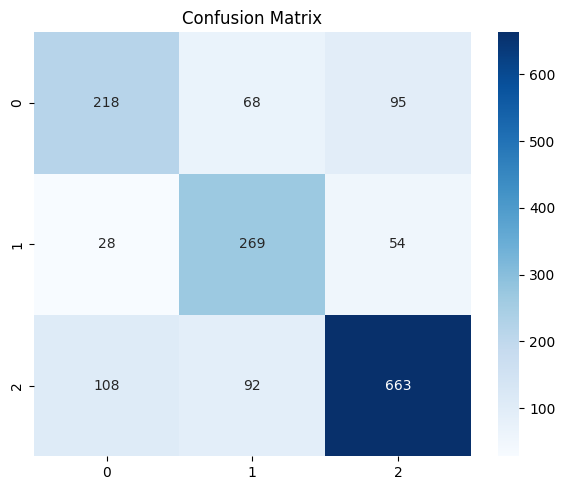

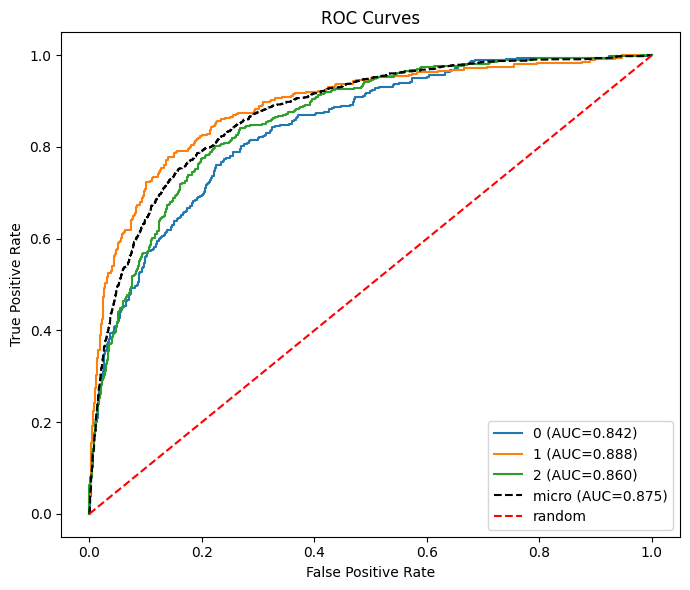

In [10]:
plot_metrics(
    metrics,
    class_names=["0","1","2"],
    save_dir = "assets/figures/val"
)

## With Test-Time-Augmentation

In [11]:
tta_transforms = build_tta_transforms(cfg_data["img_size"])

tta_val_dataset = TTADataset(
    val_df,
    cfg_data["train_dir"],
    tta_transforms
)

tta_val_loader = DataLoader(
    tta_val_dataset,
    batch_size=cfg_data["batch_size"],
    shuffle=False,
    num_workers= 8,
    pin_memory=True
)

In [12]:
val_labels_tta, val_preds_tta, val_probs_tta = gather_predictions_tta(
    model,
    tta_val_loader,
    device
)

In [13]:
metrics_tta = compute_metrics(
    val_labels_tta,
    val_preds_tta,
    val_probs_tta,
    class_names=["0","1","2"]
)
print(metrics_tta["classification_report"])

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       381
           1       0.64      0.77      0.70       351
           2       0.81      0.78      0.80       863

    accuracy                           0.73      1595
   macro avg       0.70      0.71      0.70      1595
weighted avg       0.73      0.73      0.73      1595



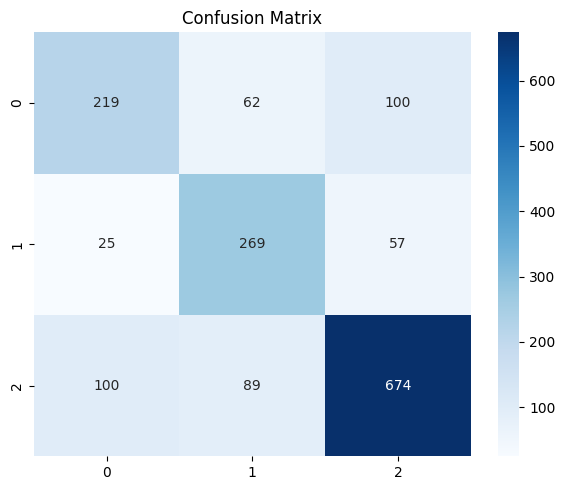

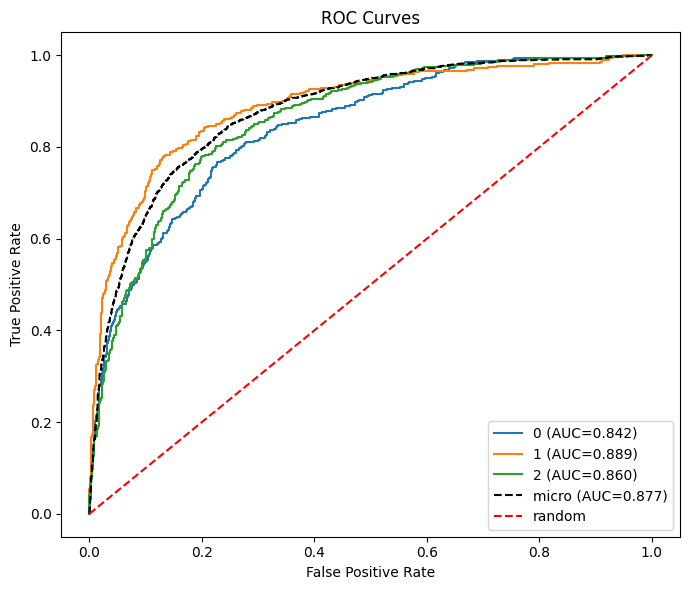

In [14]:
plot_metrics(
    metrics_tta,
    class_names=["0","1","2"],
    save_dir = "assets/figures/val_tta"
)

# Inference

In [15]:
import pandas as pd
from src.inference.predict import load_model, gather_predictions_no_labels, gather_predictions_tta_no_labels
from src.data.dataset import ChestXRayTestDataset, TTATestDataset
from src.data.transforms import build_transforms, build_tta_transforms

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/chestxray-efficientnet/outputs/models/efficientnet_b4_best.safetensors"
model = load_model(model_path, num_classes=3, device=device)

# Build transforms for inference
tfms = build_transforms(img_size=cfg_data["img_size"])["val"]
tfms_tta = build_tta_transforms(img_size=cfg_data["img_size"])

# Dataset
test_dataset = ChestXRayTestDataset(image_dir=cfg_data["test_dir"], transform=tfms)
test_tta_dataset = TTATestDataset(image_dir=cfg_data["test_dir"], transforms_list=tfms_tta)

In [16]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

test_tta_dataloader = DataLoader(
    test_tta_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

In [17]:
all_paths, all_preds, all_probs = gather_predictions_no_labels(
    model,
    test_dataloader,
    device
)

In [18]:
save_to = "assets/example_predictions/predictions.csv"
df_test = pd.DataFrame({
    "path": all_paths,
    "label": all_preds,
    "prob0": all_probs[:,0],
    "prob1": all_probs[:,1],
    "prob2": all_probs[:,2]
})
df_test.to_csv(save_to)

In [19]:
all_paths_tta, all_preds_tta, all_probs_tta = gather_predictions_tta_no_labels(
    model,
    test_tta_dataloader,
    device
)

In [20]:
save_to = "assets/example_predictions/predictions_tta.csv"
df_test_tta = pd.DataFrame({
    "path": all_paths_tta,
    "label": all_preds_tta,
    "prob0": all_probs_tta[:,0],
    "prob1": all_probs_tta[:,1],
    "prob2": all_probs_tta[:,2]
})
df_test_tta.to_csv(save_to)